# Matemáticas de la Similitud: Coseno vs. Pearson

Hasta ahora hemos usado `similarity()` como una caja negra. En esta sección, abriremos esa caja para entender la matemática exacta. Compararemos tres enfoques:
1.  Cálculo manual (NumPy).
2.  Scikit-Learn.
3.  PyTorch (GPU ready).

Primero, generemos datos sintéticos: tres vectores (`d1`, `d2`, `d3`) con diferentes relaciones entre sí.

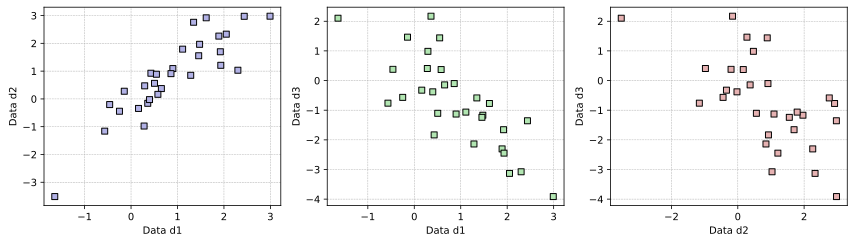

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Generar datos
N = 30

# Vectores de datos
d1 = np.random.randn(N) + 1 # añadimos un offset para diferenciar Pearson vs Coseno
d2 = d1 + np.random.randn(N) # Positivamente correlacionado con d1
d3 = -d1 + np.random.randn(N) # Negativamente correlacionado con d1

# Visualización
_, axs = plt.subplots(1, 3, figsize=(12, 3.5))

axs[0].plot(d1, d2, 'ks', markerfacecolor=[.7, .7, .9])
axs[0].set(xlabel='Data d1', ylabel='Data d2')

axs[1].plot(d1, d3, 'ks', markerfacecolor=[.7, .9, .7])
axs[1].set(xlabel='Data d1', ylabel='Data d3')

axs[2].plot(d2, d3, 'ks', markerfacecolor=[.9, .7, .7])
axs[2].set(xlabel='Data d2', ylabel='Data d3')

for a in axs: a.grid(linestyle='--', linewidth=.5)

plt.tight_layout()
plt.show()

## 1. Similitud Coseno: Manual vs Scikit-Learn

La fórmula de la similitud coseno es el producto punto de los vectores dividido por el producto de sus magnitudes (normas).

$$\text{Cosine}(A, B) = \frac{A \cdot B}{||A|| \cdot ||B||}$$



Nota importante sobre **Scikit-Learn**: Esta librería espera matrices (listas de vectores), no vectores individuales 1D. Por eso usaremos `.reshape(1, -1)` para convertir nuestro arreglo de forma `(30,)` a `(1, 30)`.

In [2]:
# Similitud coseno manual
num = sum(d1 * d2)
den = sum(d1 * d1) * sum(d2**2) # Nota: esto es magnitud al cuadrado, falta raíz si lo hacemos separado
# Corrección en la fórmula completa abajo:
cossim_manual = num / np.sqrt(den)
print(f'Cálculo manual: Similitud Coseno entre d1 y d2 es {cossim_manual:.4f}')

# Comprobación contra sklearn
# Nota: sklearn necesita arrays 2D, por eso hacemos reshape
cossim_sklearn = cosine_similarity(d1.reshape(1, -1), d2.reshape(1, -1))

print(f'Sci-kit learn:  Similitud Coseno entre d1 y d2 es {cossim_sklearn[0][0]:.4f}')

# Verificar formas
print(f'Shape con reshape: {d1.reshape(1, -1).shape}')
print(f'Shape original:    {d1.shape}')

Cálculo manual: Similitud Coseno entre d1 y d2 es 0.9091
Sci-kit learn:  Similitud Coseno entre d1 y d2 es 0.9091
Shape con reshape: (1, 30)
Shape original:    (30,)


## 2. La Conexión con la Correlación de Pearson

Aquí está el secreto mejor guardado: **La Correlación de Pearson es simplemente la Similitud Coseno aplicada a datos centrados en la media.**



Si a los vectores les restamos su promedio (los centramos en el origen 0,0), el ángulo entre ellos cambia.
* **Coseno:** Importa la dirección desde el origen absoluto.
* **Pearson:** Importa cómo varían juntos respecto a sus medias.

In [5]:
# Centrado en la media (Mean-centering)
d1m = d1 - np.mean(d1)
d2m = d2 - np.mean(d2)

# Cálculo manual de Pearson
num = sum(d1m * d2m)
den = sum(d1m * d1m) * sum(d2m * d2m)
corr_manual = num / np.sqrt(den)

# Numpy corrcoef (implementación estándar de Pearson)
corr_np = np.corrcoef(d1, d2)[0, 1]

# Similitud coseno usando datos centrados
cossimM_sklearn = cosine_similarity(d1m.reshape(1, -1), d2m.reshape(1, -1))

# Imprimir todos los resultados
print(f'Cálculo Manual: Pearson correlation entre d1 y d2 es {corr_manual:.7f}')
print(f'Numpy corrcoef: Pearson correlation entre d1 y d2 es {corr_np:.7f}')
print(f'Sci-kit learn:  Coseno con datos centrados (d1m, d2m) es {cossimM_sklearn[0][0]:.7f}')
print(f'Sci-kit learn:  Coseno con datos originales (d1, d2) es  {cossim_sklearn[0][0]:.7f}')

Cálculo Manual: Pearson correlation entre d1 y d2 es 0.8849368
Numpy corrcoef: Pearson correlation entre d1 y d2 es 0.8849368
Sci-kit learn:  Coseno con datos centrados (d1m, d2m) es 0.8849368
Sci-kit learn:  Coseno con datos originales (d1, d2) es  0.9090753


## 3. Implementación en PyTorch

En Deep Learning (Transformers, BERT, GPT), trabajamos con tensores. PyTorch tiene su propia implementación optimizada.

Ojo: PyTorch es estricto con los tipos. No puedes pasarle listas de Numpy directamente, debes convertirlas a `torch.tensor`.

In [6]:
# Esto daría error porque d1 es numpy:
# torch.cosine_similarity(d1, d2)

# Forma correcta: convertir a Tensores
# Nota: cosine_similarity en torch espera dimensiones claras, a veces es mejor usar view
print(f"Directo (puede dar warning dimensiones): {torch.cosine_similarity(torch.tensor(d1), torch.tensor(d2), dim=0)}")

# La forma más segura para batches (1, N):
cossim_torch = torch.cosine_similarity(torch.tensor(d1).view(1, -1), torch.tensor(d2).view(1, -1))

print(f'sklearn: Similitud Coseno entre d1 y d2 es {cossim_torch.item():.7f}')
print(f'Torch:   Similitud Coseno entre d1 y d2 es {cossim_sklearn[0][0]:.7f}')

Directo (puede dar warning dimensiones): 0.9090752923672465
sklearn: Similitud Coseno entre d1 y d2 es 0.9090753
Torch:   Similitud Coseno entre d1 y d2 es 0.9090753


## 4. Visualización Final con Métricas

Finalmente, redibujamos los gráficos iniciales pero ahora incluimos el valor calculado de similitud coseno en el título para tener una referencia visual de qué significan los números.

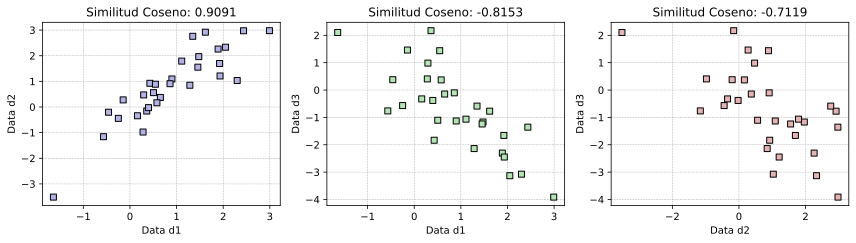

In [7]:
# Calcular similitudes coseno con PyTorch
cs_d12 = torch.cosine_similarity(torch.tensor(d1).view(1, -1), torch.tensor(d2).view(1, -1))
cs_d13 = torch.cosine_similarity(torch.tensor(d1).view(1, -1), torch.tensor(d3).view(1, -1))
cs_d23 = torch.cosine_similarity(torch.tensor(d2).view(1, -1), torch.tensor(d3).view(1, -1))

# Visualizar
_, axs = plt.subplots(1, 3, figsize=(12, 3.5))

axs[0].plot(d1, d2, 'ks', markerfacecolor=[.7, .7, .9])
axs[0].set(xlabel='Data d1', ylabel='Data d2', title=f'Similitud Coseno: {cs_d12.item():.4f}')

axs[1].plot(d1, d3, 'ks', markerfacecolor=[.7, .9, .7])
axs[1].set(xlabel='Data d1', ylabel='Data d3', title=f'Similitud Coseno: {cs_d13.item():.4f}')

axs[2].plot(d2, d3, 'ks', markerfacecolor=[.9, .7, .7])
axs[2].set(xlabel='Data d2', ylabel='Data d3', title=f'Similitud Coseno: {cs_d23.item():.4f}')

for a in axs: a.grid(linestyle='--', linewidth=.5)

plt.tight_layout()
plt.show()

# Análisis de Resultados: Geometría vs. Estadística

En esta práctica hemos desmitificado el cálculo de similitud. Aquí las conclusiones clave:

### 1. El Impacto del "Centrado"
Observamos que `Cosine(d1, d2)` **NO** es igual a `Pearson(d1, d2)` originalmente.
* Sin embargo, cuando hicimos `d1 - mean` y `d2 - mean`, los resultados se volvieron idénticos.
* **Conclusión:** La correlación de Pearson es simplemente la similitud coseno "insensible al sesgo". En NLP, a veces preferimos el Coseno puro porque el "cero" (ausencia de palabras) es importante.

### 2. Dimensiones en Librerías
* **Scikit-Learn:** Es quisquilloso con las dimensiones. Siempre espera una matriz de forma `(muestras, características)`. Un solo vector debe ser reformateado a `(1, N)`.
* **PyTorch:** Es flexible pero estricto con los tipos. Requiere Tensores explícitos. La función `view(1, -1)` es el equivalente a `reshape` de Numpy y es vital para asegurar que estamos comparando filas con filas.

### 3. Interpretación de Valores
En los gráficos finales:
* **~0.90:** Indica vectores que apuntan casi a la misma dirección (alta similitud).
* **~ -0.60:** Indica vectores que apuntan en direcciones opuestas. En embeddings, esto significaría antónimos o contextos opuestos.

Dominar estas operaciones es crucial porque dentro de la arquitectura Transformer (en el mecanismo de Atención), esta operación de producto punto se realiza millones de veces por segundo.

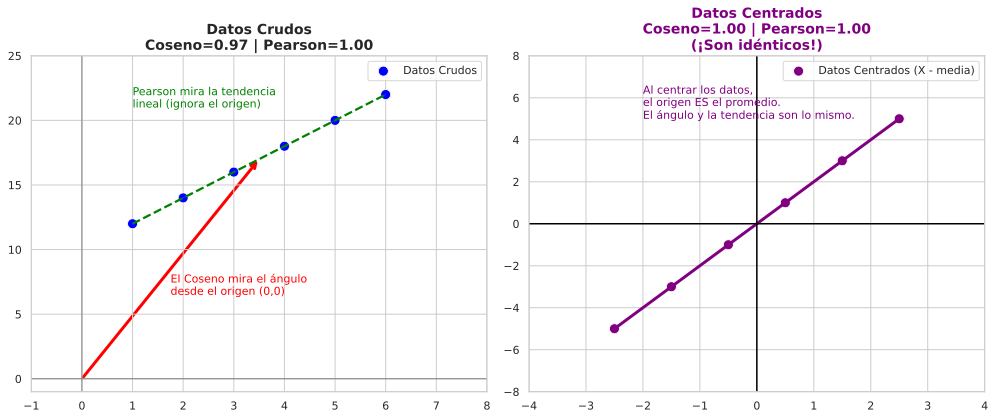

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

# Configurar el estilo visual con Seaborn
sns.set_theme(style="whitegrid")

# --- 1. Generar Datos ---
# Creamos dos vectores que tienen una correlación lineal PERFECTA (Pearson = 1.0)
# pero diferentes escalas y desplazamientos (Coseno < 1.0).
x = np.array([1, 2, 3, 4, 5, 6])
# 'y' es 'x' multiplicado por 2 y desplazado 10 unidades hacia arriba.
y = x * 2 + 10

# Datos centrados (restamos la media)
x_centered = x - x.mean()
y_centered = y - y.mean()

# --- 2. Cálculos de Similitud ---
# Pearson (será 1.0)
pearson_val, _ = pearsonr(x, y)
# Coseno en datos crudos (será alto, pero no 1.0)
cosine_raw = 1 - cosine(x, y)
# Coseno en datos centrados (será exactamente igual a Pearson, 1.0)
cosine_centered = 1 - cosine(x_centered, y_centered)


# --- 3. Visualización ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- PANEL IZQUIERDO: Datos Crudos (La visión del Coseno vs Pearson) ---
sns.scatterplot(x=x, y=y, ax=axes[0], color='blue', s=100, label='Datos Crudos')

# Dibujar vectores desde el origen (0,0) hasta el punto medio de los datos
# Esto representa lo que "mira" la Similitud del Coseno.
origin = np.zeros(2)
mean_point = np.array([x.mean(), y.mean()])

# Flecha que representa el vector promedio (visión Coseno)
axes[0].annotate('', xy=(x.mean(), y.mean()), xytext=(0, 0),
                 arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=3),
                 zorder=0)
axes[0].text(x.mean()/2, y.mean()/2 - 2, "El Coseno mira el ángulo\ndesde el origen (0,0)", color='red', fontsize=11)

# Línea de tendencia (Pearson)
sns.regplot(x=x, y=y, ax=axes[0], scatter=False, color='green', line_kws={'linestyle':'--'})
axes[0].text(x.min(), y.max()-1, "Pearson mira la tendencia\nlineal (ignora el origen)", color='green', fontsize=11)

# Ajustes del gráfico
axes[0].axhline(0, color='grey', lw=1)
axes[0].axvline(0, color='grey', lw=1)
axes[0].set_title(f"Datos Crudos\nCoseno={cosine_raw:.2f} | Pearson={pearson_val:.2f}", fontsize=14, fontweight='bold')
axes[0].set_xlim(-1, 8)
axes[0].set_ylim(-1, 25)
axes[0].legend()


# --- PANEL DERECHO: Datos Centrados (Cuando Coseno == Pearson) ---
sns.scatterplot(x=x_centered, y=y_centered, ax=axes[1], color='purple', s=100, label='Datos Centrados (X - media)')

# Línea de tendencia
sns.regplot(x=x_centered, y=y_centered, ax=axes[1], scatter=False, color='purple', line_kws={'lw':3})

# Flechas indicando que ahora la tendencia pasa por el origen
axes[1].annotate('', xy=(x_centered[-1], y_centered[-1]), xytext=(0, 0),
                 arrowprops=dict(facecolor='purple', arrowstyle='->', lw=2), zorder=0)

axes[1].text(-2, 5, "Al centrar los datos,\nel origen ES el promedio.\nEl ángulo y la tendencia son lo mismo.", color='purple', fontsize=11)

# Ajustes del gráfico
axes[1].axhline(0, color='black', lw=1.5) # Origen remarcado
axes[1].axvline(0, color='black', lw=1.5)
axes[1].set_title(f"Datos Centrados\nCoseno={cosine_centered:.2f} | Pearson={pearson_val:.2f}\n(¡Son idénticos!)", fontsize=14, fontweight='bold', color='purple')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-8, 8)
axes[1].legend()

plt.tight_layout()
plt.show()

# (Opcional) Guardar la imagen para LinkedIn
# fig.savefig('diferencia_coseno_pearson.png', dpi=300)